# OpenGL Compute Shaders: Accuracy of Math Functions

This notebook is the second in a series of notebooks about general-purpose GPU (GPGPU) computing using OpenGL's compute shaders.  In working towards a GPU-based implementation of the venerable Solar Position Algorithm ([Reda & Andreas 2004](https://doi.org/10.1016/j.solener.2003.12.003)) I found that the `asin` provided by GLSL is not as accurate as I had expected, even considering the reduced precision of 32-bit floats.  This notebook examines the (in)accuracy of this GPU's GLSL implementations of some basic functions useful for scientific programming.

In [1]:
import moderngl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

I use the handy helper function from my "first steps" notebook here as well.  This encapsulates (1) the boilerplate necessary to shuttle data to and from the GPU and (2) the initialization code on the GPU side needed prior to performing the actual computation of interest.

In [2]:
context = moderngl.create_standalone_context(require=430)

def compute(job, inputs, groupsize=1024):
    N = len(inputs)

    SHADER_SOURCE = ("""
    #version 430

    #define GROUPSIZE %%N%%

    layout(local_size_x=GROUPSIZE, local_size_y=1, local_size_z=1) in;

    layout (std430, binding=0) buffer in_0
    {
        float inputs[1];
    };
    
    layout (std430, binding=1) buffer out_0
    {
        float outputs[1];
    };
    
    void main()
    {
        const int local_id = int(gl_LocalInvocationID.x);
        const int group_id = int(gl_WorkGroupID.x);
        const int i = group_id * GROUPSIZE + local_id;
        %%JOB%%
    }
    """
    .replace("%%N%%", str(min(len(inputs), groupsize)))
    .replace("%%JOB%%", job)
    )

    compute_shader = context.compute_shader(SHADER_SOURCE)
    
    buffer_inputs = context.buffer(inputs)
    buffer_outputs = context.buffer(reserve=inputs.nbytes)

    buffer_inputs.bind_to_storage_buffer(0)
    buffer_outputs.bind_to_storage_buffer(1)
    
    n_group = 1 + (len(inputs)-1) // groupsize
    compute_shader.run(group_x=n_group)
    
    outputs = np.frombuffer(buffer_outputs.read(), dtype=np.float32)
    return outputs

Here I am using numpy's implementations as the ground truth, using standard 64-bit floats on the numpy side.  My goal here is not to have a perfect apples to apples comparison of outputs given identical inputs, but rather to get a sense for the all-in differences between "normal" (64-bit) computations running on the CPU and the 32-bit GPU-based computations I'm doing.  So the differences here are presumably some combination of the differences in precision, function implementation, and other factors like whatever SIMD is active here (not sure there is any on this AMD CPU).

So let's calculate some differences!  Some functions have a clear domain of maximum relevance; for the others I chose a reasonable but arbitrary domain.

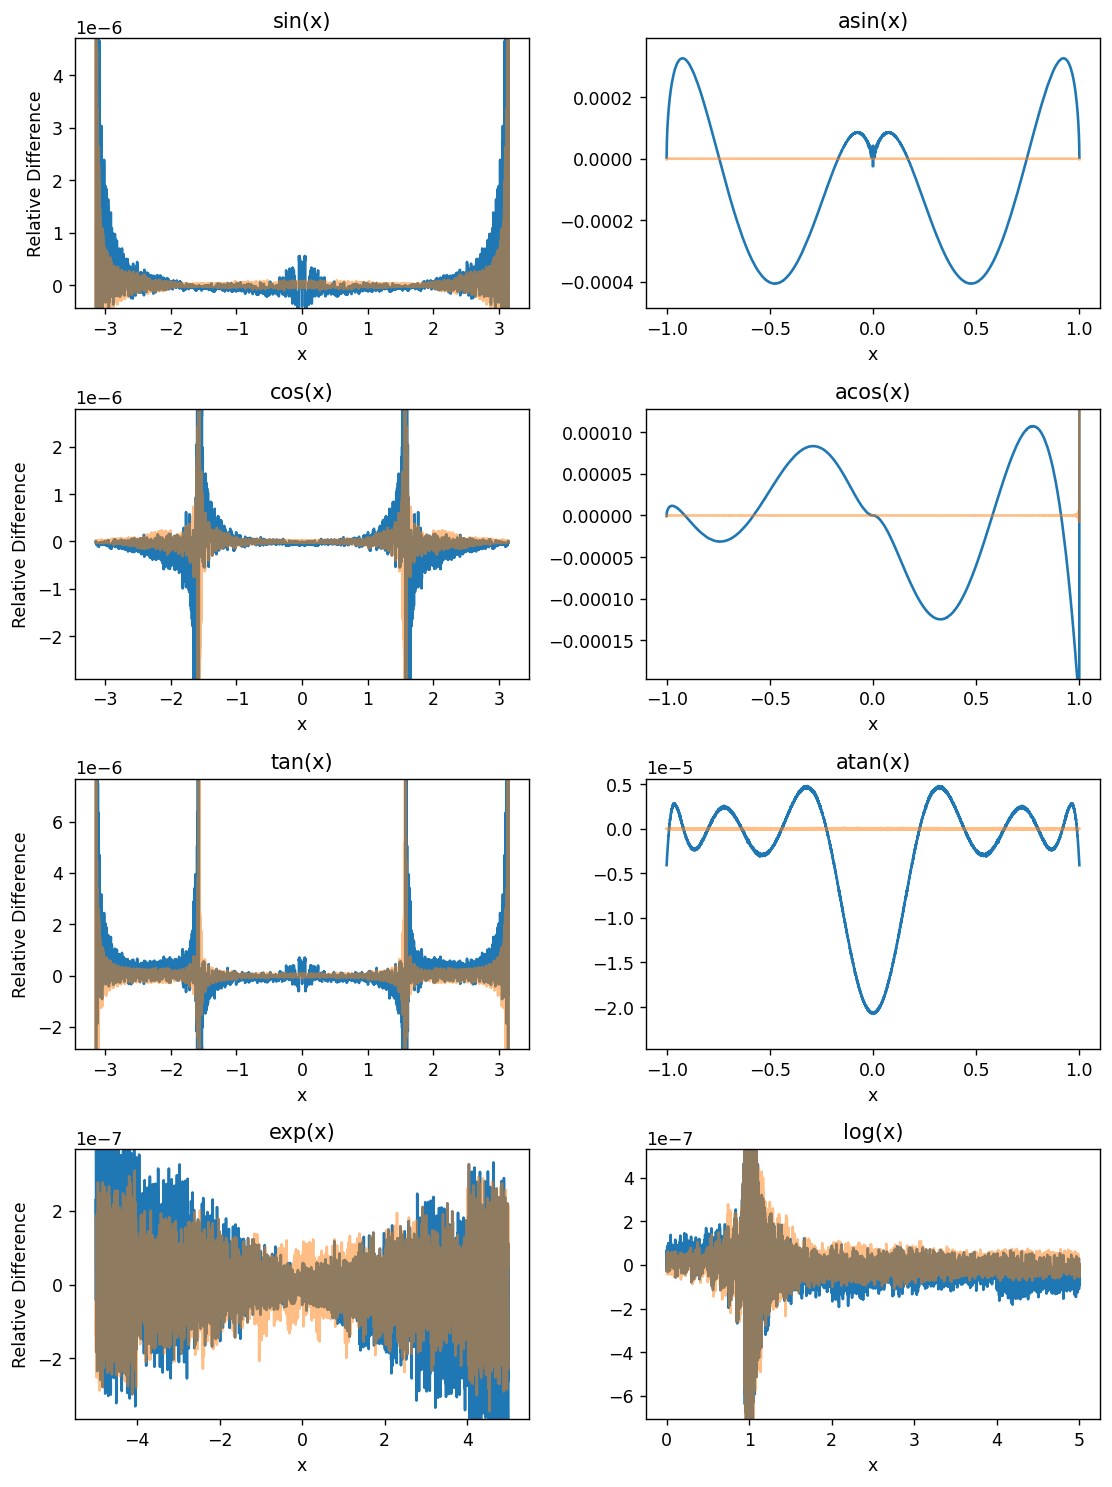

In [3]:
def compare(np_func, glsl_func, xlo, xhi, ax):
    x = np.linspace(xlo + 1e-5, xhi - 1e-5, num=5000)
    cpu64 = np_func(x)
    cpu32 = np_func(x.astype('f4'))
    gpu = compute(f'outputs[i] = {glsl_func}(inputs[i]);', x.astype('f4'))
    gpu_diff = gpu / cpu64 - 1
    prec_diff = cpu32 / cpu64 - 1
    ax.plot(x, gpu_diff)
    ax.plot(x, prec_diff, alpha=0.5)
    ax.set_title(f'{glsl_func}(x)')
    ax.set_ylim(1.2*np.quantile(gpu_diff, 0.01), 1.2*np.quantile(gpu_diff, 0.99))
    return gpu_diff


combos = [
    (np.sin, 'sin', np.arcsin, 'asin', -np.pi, np.pi, -1, 1),
    (np.cos, 'cos', np.arccos, 'acos', -np.pi, np.pi, -1, 1),
    (np.tan, 'tan', np.arctan, 'atan', -np.pi, np.pi, -1, 1),
    (np.exp, 'exp', np.log, 'log', -5, 5, 0, 5),
]
fig, axes = plt.subplots(len(combos), 2, figsize=(9, 3*len(combos)), dpi=125)

results = {}

for i, (forward_func, glsl_forward_func, backward_func, glsl_backward_func, xflo, xfhi, xblo, xbhi) in enumerate(combos):
    forward_diff = compare(forward_func, glsl_forward_func, xflo, xfhi, axes[i, 0])
    backward_diff = compare(backward_func, glsl_backward_func, xblo, xbhi, axes[i, 1])

    axes[i, 0].set_ylabel('Relative Difference')
    axes[i, 0].set_xlabel('x')
    axes[i, 1].set_xlabel('x')

    results[glsl_forward_func] = pd.Series(forward_diff).quantile([0, 0.001, 0.999, 1])
    results[glsl_backward_func] = pd.Series(backward_diff).quantile([0, 0.001, 0.999, 1])

fig.tight_layout()

Here, blue is the difference between GPU and 64-bit CPU results and transparent orange is the difference between 32- and 64-bit CPU results for comparison.

Since we're dealing with (signed) 32-bit floats with 23 significand bits, we can only expect 7-ish decimal digits of accuracy at best, which is about what we see for several functions here.  In fact, the GPU errors for the majority of functions are mainly explained by just the precision difference, suggesting the underlying implementation is pretty good.
However, some of them are way less accurate -- the GLSL $\arccos$ and $\arcsin$ implementations have relative errors way out at ~$\pm 10^{-4}$!  I wonder why those are so large compared with the others.  $\arctan$ at least gets a shout out for beating $\arcsin$ and $\arccos$ by 1–2 orders of magnitude, but it's still quite bad...

The forward trig functions have some pathological cases where they approach zero or (in the case of $\tan$ and $\log$) diverge.  Remember that these are relative (not absolute) differences.

Here are some summary statistics in tabular form, for reference:

In [4]:
pd.set_option('display.precision', 2)
pd.DataFrame(results)

,sin,asin,cos,acos,tan,atan,exp,log
0.00e+00,-8.34e-06,-4.06e-04,-9.03e-05,-2.34e-04,-1.45e-04,-2.08e-05,-4.39e-07,-2.21e-04
1.00e-03,-9.48e-07,-4.05e-04,-4.68e-05,-2.21e-04,-2.90e-05,-2.07e-05,-4.13e-07,-3.97e-06
9.99e-01,5.78e-05,3.26e-04,2.89e-05,1.07e-04,8.80e-05,4.76e-06,3.95e-07,4.43e-06
1.00e+00,1.12e-02,3.26e-04,1.45e-04,4.52e-04,1.12e-02,4.81e-06,4.55e-07,3.61e-05


I don't have much use for the hyperbolic trig functions, but might as well try them out too:

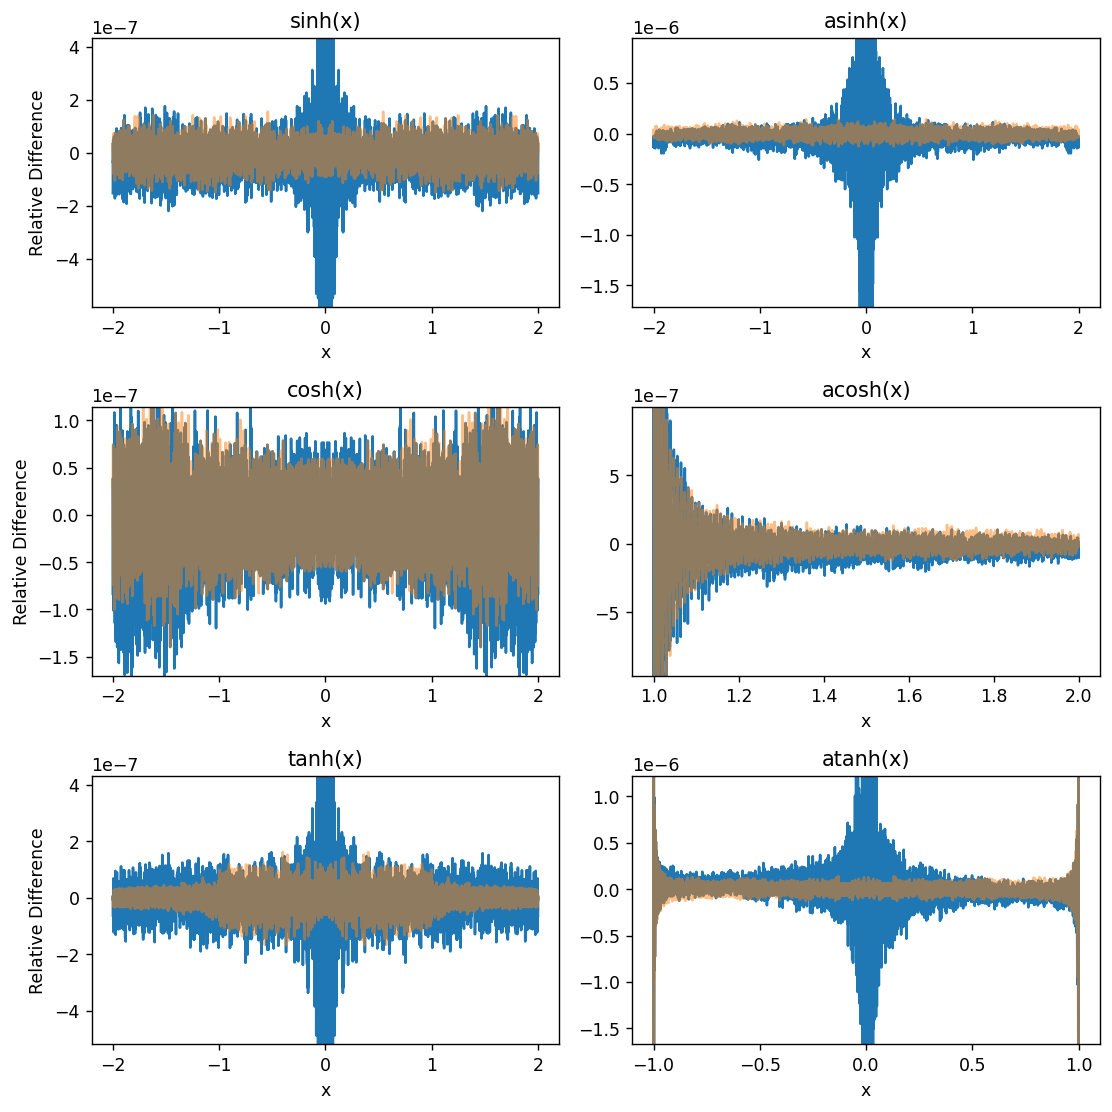

In [5]:
combos = [
    (np.sinh, 'sinh', np.arcsinh, 'asinh', -2, 2, -2, 2),
    (np.cosh, 'cosh', np.arccosh, 'acosh', -2, 2, 1, 2),
    (np.tanh, 'tanh', np.arctanh, 'atanh', -2, 2, -1, 1),
]
fig, axes = plt.subplots(len(combos), 2, figsize=(9, 3*len(combos)), dpi=125)

results = {}

for i, (forward_func, glsl_forward_func, backward_func, glsl_backward_func, xflo, xfhi, xblo, xbhi) in enumerate(combos):
    forward_diff = compare(forward_func, glsl_forward_func, xflo, xfhi, axes[i, 0])
    backward_diff = compare(backward_func, glsl_backward_func, xblo, xbhi, axes[i, 1])

    axes[i, 0].set_ylabel('Relative Difference')
    axes[i, 0].set_xlabel('x')
    axes[i, 1].set_xlabel('x')

    results[glsl_forward_func] = pd.Series(forward_diff).quantile([0, 0.001, 0.999, 1])
    results[glsl_backward_func] = pd.Series(backward_diff).quantile([0, 0.001, 0.999, 1])

fig.tight_layout()

For a lark, let's try to make an improved $\arcsin$ implementation.  This GPU's implementation of `atan`, although having larger error than I'd like, is still better than its `asin`, and Wikipedia [claims](https://en.wikipedia.org/wiki/Inverse_trigonometric_functions#Relationships_among_the_inverse_trigonometric_functions) that you can calculate $\arcsin$ using $\arctan$:

$$
\arcsin(x) = \arctan \left( \frac{x}{\sqrt{1-x^2}} \right)
$$

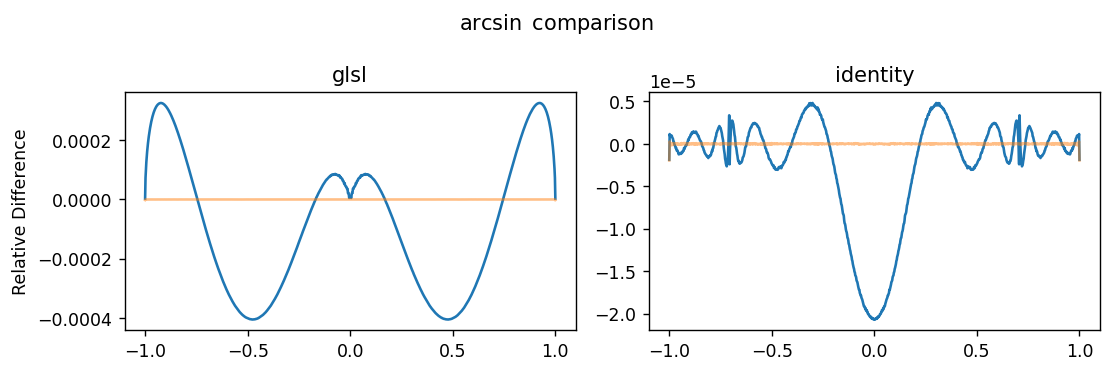

In [6]:
x = np.linspace(-1+1e-5, 1-1e-5, num=1000)
glsl_asin = compute('outputs[i] = asin(inputs[i]);', x.astype('f4'))
identity_asin = compute('outputs[i] = atan(inputs[i], sqrt(1-pow(inputs[i], 2)));', x.astype('f4'))
numpy_64_asin = np.arcsin(x)
numpy_32_asin = np.arcsin(x.astype('f4'))

fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=125)

axes[0].plot(x, glsl_asin/numpy_64_asin - 1)
axes[0].plot(x, numpy_32_asin/numpy_64_asin - 1, alpha=0.5)
axes[0].set_title('glsl')
axes[0].set_ylabel('Relative Difference')

axes[1].plot(x, identity_asin/numpy_64_asin - 1)
axes[1].plot(x, numpy_32_asin/numpy_64_asin - 1, alpha=0.5)
axes[1].set_title('identity')

fig.suptitle(r'$\arcsin$ comparison')
fig.tight_layout()

In [7]:
pd.DataFrame({
    'glsl': glsl_asin/numpy_64_asin - 1,
    'identity': identity_asin/numpy_64_asin - 1,
    'precision': numpy_32_asin/numpy_64_asin - 1,
}).quantile([0, 0.001, 0.999, 1])

,glsl,identity,precision
0.00e+00,-4.06e-04,-2.07e-05,-1.95e-06
1.00e-03,-4.06e-04,-2.07e-05,-1.95e-06
9.99e-01,3.26e-04,4.82e-06,2.88e-07
1.00e+00,3.26e-04,4.82e-06,2.88e-07


So this replacement is indeed much better!  Although there is still some room for improvement, because as we saw earlier, the `atan` implementation it's based on is flawed.  Potential alternatives with even lower error: CORDIC, Maclaurin series, Chebyshev polynomials, lookup tables...

Finally, the GPU info:

In [8]:
!python -m moderngl

moderngl 5.6.4
--------------
vendor: AMD
renderer: AMD RENOIR (LLVM 13.0.1, DRM 3.46, 5.18.10-76051810-generic)
version: 4.6 (Core Profile) Mesa 22.0.1
python: 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
platform: linux
code: 460
